Adsorption Energies
======================================================

Pre-trained ODAC models are versatile across various MOF-related tasks. To begin, we'll start with a fundamental application: calculating the adsorption energy for a single CO<sub>2</sub> molecule. This serves as an excellent and simple demonstration of what you can achieve with these datasets and models.

For predicting the adsorption energy of a single CO<sub>2</sub> molecule within a MOF structure, the adsorption energy ($E_{\mathrm{ads}}$) is defined as:

$$ E_{\mathrm{ads}} = E_{\mathrm{MOF+CO2}} - E_{\mathrm{MOF}} - E_{\mathrm{CO2}} \tag{1}$$

Each term on the right-hand side represents the energy of the relaxed state of the indicated chemical system. For a comprehensive understanding of our methodology for computing these adsorption energies, please refer to our [paper](https://doi.org/10.1021/acscentsci.3c01629).

## Loading Pre-trained Models

````{admonition} Need to install fairchem-core or get UMA access or getting permissions/401 errors?
:class: dropdown


1. Install the necessary packages using pip, uv etc
```{code-cell} ipython3
:tags: [skip-execution]

! pip install fairchem-core fairchem-data-oc fairchem-applications-cattsunami
```

2. Get access to any necessary huggingface gated models
    * Get and login to your Huggingface account
    * Request access to https://huggingface.co/facebook/UMA
    * Create a Huggingface token at https://huggingface.co/settings/tokens/ with the permission "Permissions: Read access to contents of all public gated repos you can access"
    * Add the token as an environment variable using `huggingface-cli login` or by setting the HF_TOKEN environment variable.

```{code-cell} ipython3
:tags: [skip-execution]

# Login using the huggingface-cli utility
! huggingface-cli login

# alternatively,
import os
os.environ['HF_TOKEN'] = 'MY_TOKEN'
```

````


A pre-trained model can be loaded using `FAIRChemCalculator`. In this example, we'll employ UMA to determine the CO<sub>2</sub> adsorption energies.

In [1]:
from fairchem.core import FAIRChemCalculator, pretrained_mlip

predictor = pretrained_mlip.get_predict_unit("uma-s-1p1")
calc = FAIRChemCalculator(predictor, task_name="odac")

## Adsorption in rigid MOFs: CO<sub>2</sub> Adsorption Energy in Mg-MOF-74

Let's apply our knowledge to Mg-MOF-74, a widely studied MOF known for its excellent CO<sub>2</sub> adsorption properties. Its structure comprises magnesium atomic complexes connected by a carboxylated and oxidized benzene ring, serving as an organic linker. Previous studies consistently report the CO<sub>2</sub> adsorption energy for Mg-MOF-74 to be around -0.40 eV [[1]](https://doi.org/10.1039/C4SC02064B) [[2]](https://doi.org/10.1039/C3SC51319J) [[3]](https://doi.org/10.1021/acs.jpcc.8b00938).

Our goal is to verify if we can achieve a similar value by performing a simple single-point calculation using UMA. In the ODAC23 dataset, all MOF structures are identified by their CSD (Cambridge Structural Database) code. For Mg-MOF-74, this code is **OPAGIX**. We've extracted a specific `OPAGIX+CO2` configuration from the dataset, which exhibits the lowest adsorption energy among its counterparts.

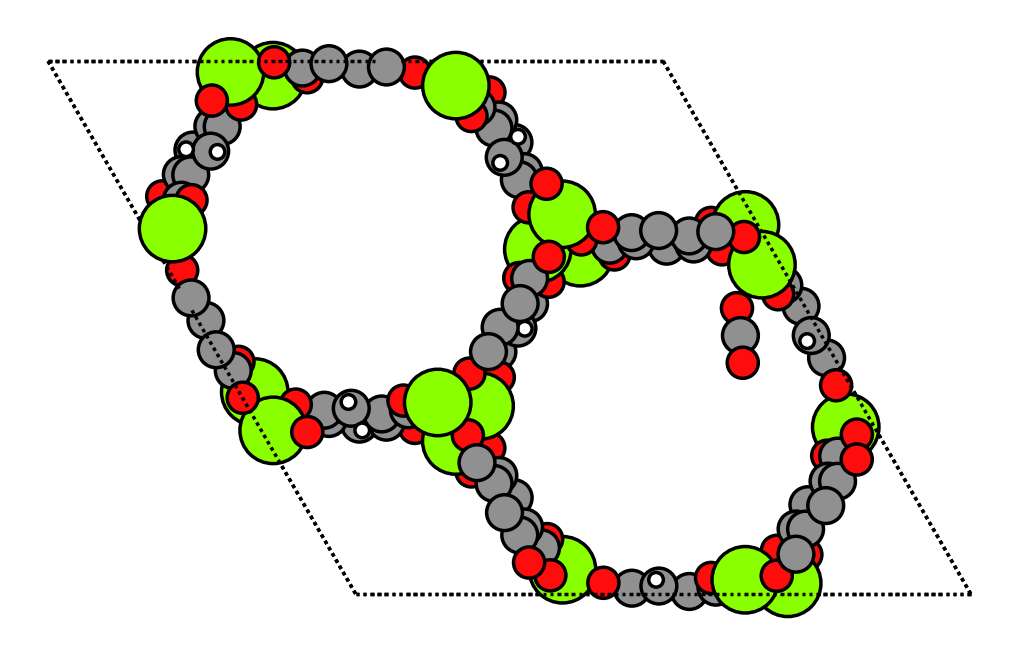

In [2]:
import matplotlib.pyplot as plt
from ase.io import read
from ase.visualize.plot import plot_atoms

mof_co2 = read("structures/OPAGIX_w_CO2.cif")
mof = read("structures/OPAGIX.cif")
co2 = read("structures/co2.xyz")

fig, ax = plt.subplots(figsize=(5, 4.5), dpi=250)
plot_atoms(mof_co2, ax)
ax.set_axis_off()

The final step in calculating the adsorption energy involves connecting the `FAIRChemCalculator` to each relaxed structure: `OPAGIX+CO2`, `OPAGIX`, and `CO2`. The structures used here are already relaxed from ODAC23. For simplicity, we assume here that further relaxations can be neglected. We will show how to go beyond this assumption in the next section.

In [3]:
mof_co2.calc = calc
mof.calc = calc
co2.calc = calc

E_ads = (
    mof_co2.get_potential_energy()
    - mof.get_potential_energy()
    - co2.get_potential_energy()
)

print(f"Adsorption energy of CO2 in Mg-MOF-74: {E_ads:.3f} eV")

Adsorption energy of CO2 in Mg-MOF-74: -0.459 eV


## Adsorption in flexible MOFs

The adsorption energy calculation method outlined above is typically performed with rigid MOFs for simplicity. Both experimental and modeling literature have shown, however, that MOF flexibility can be important in accurately capturing the underlying chemistry of adsorption [[1]](https://arxiv.org/abs/2506.09256) [[2]](https://pubs.acs.org/doi/10.1021/jacs.7b01688) [[3]](https://www.nature.com/articles/nature15732). In particular, uptake can be improved by treating MOFs as flexible. Two types of MOF flexibility can be considered: intrinsic flexibility and deformation induced by guest molecules. In the Open DAC Project, we consider the latter MOF deformation by allowing the atomic positions of the MOF to relax during geometry optimization [[4]](https://pubs.acs.org/doi/10.1021/acscentsci.3c01629). The addition of additional degrees of freedoms can complicate the computation of the adsorption energy and necessitates an extra step in the calculation procedure.

The figure below shows water adsorption in the MOF with CSD code WOBHEB with added defects (`WOBHEB_0.11_0`) from a DFT simulation. A typical adsorption energy calculation would only seek to capture the effects shaded in purple, which include both chemisorption and non-bonded interactions between the host and guest molecule. When allowing the MOF to relax, however, the adsorption energy also includes the energetic effect of the MOF deformation highlighted in green.

![](./WOBHEB_flexible.png)

To account for this deformation, it is vital to use the most energetically favorable MOF geometry for the empty MOF term in Eqn. 1. Including MOF atomic coordinates as degrees of freedom can result in three possible outcomes:

1. The MOF does not deform, so the energies of the relaxed empty MOF and the MOF in the adsorbed state are the same
2. The MOF deforms to a less energetically favorable geometry than its ground state
3. The MOF locates a new energetically favorable geoemtry relative to the empty MOF relaxation

The first outcome requires no additional computation because the MOF rigidity assumption is valid. The second outcome represents physical and reversible deformation where the MOF returns to its empty ground state upon removal of the guest molecule. The third outcome is often the result of the guest molecule breaking local symmetry. We also found cases in ODAC in which both outcomes 2 and 3 occur within the same MOF.

To ensure the most energetically favorable empty MOF geometry is found, an addition empty MOF relaxation should be performed after MOF + adsorbate relaxation. The guest molecule should be removed, and the MOF should be relaxed starting from its geometry in the adsorbed state. If all deformation is reversible, the MOF will return to its original empty geometry. Otherwise, the lowest energy (most favorable) MOF geometry should be taken as the reference energy, $E_{\mathrm{MOF}}$, in Eqn. 1.

### H<sub>2</sub>O Adsorption Energy in Flexible WOBHEB with UMA

The first part of this tutorial demonstrates how to perform a single point adsorption energy calculation using UMA. To treat MOFs as flexible, we perform all calculations on geometries determined by geometry optimization. The following example corresponds to the figure shown above (H<sub>2</sub>O adsorption in `WOBHEB_0.11_0`).

**In this tutorial, $E_{x}(r_{y})$ corresponds to the energy of $x$ determined from geometry optimization of $y$.**

First, we obtain the energy of the empty MOF from relaxation of only the MOF: $E_{\mathrm{MOF}}(r_{\mathrm{MOF}})$

In [4]:
import ase.io
from ase.optimize import BFGS

mof = ase.io.read("structures/WOBHEB_0.11.cif")
mof.calc = calc
relax = BFGS(mof)
relax.run(fmax=0.05)
E_mof_empty = mof.get_potential_energy()
print(f"Energy of empty MOF: {E_mof_empty:.3f} eV")

      Step     Time          Energy          fmax
BFGS:    0 21:21:25    -1077.274064        0.206406


BFGS:    1 21:21:25    -1077.276780        0.152729


BFGS:    2 21:21:25    -1077.281943        0.169929


BFGS:    3 21:21:25    -1077.284771        0.155755


BFGS:    4 21:21:25    -1077.288835        0.108767


BFGS:    5 21:21:26    -1077.291023        0.086450


BFGS:    6 21:21:26    -1077.293360        0.093434


BFGS:    7 21:21:26    -1077.295412        0.100101


BFGS:    8 21:21:26    -1077.297827        0.102523


BFGS:    9 21:21:26    -1077.300016        0.091609


BFGS:   10 21:21:27    -1077.302008        0.078979


BFGS:   11 21:21:27    -1077.304136        0.105558


BFGS:   12 21:21:27    -1077.306721        0.087934


BFGS:   13 21:21:27    -1077.309513        0.086339


BFGS:   14 21:21:28    -1077.312262        0.086863


BFGS:   15 21:21:28    -1077.314701        0.106268


BFGS:   16 21:21:28    -1077.316988        0.106189


BFGS:   17 21:21:28    -1077.319483        0.085426


BFGS:   18 21:21:28    -1077.322264        0.109656


BFGS:   19 21:21:29    -1077.325136        0.148688


BFGS:   20 21:21:29    -1077.327764        0.125920


BFGS:   21 21:21:29    -1077.329922        0.069091


BFGS:   22 21:21:29    -1077.331950        0.087277


BFGS:   23 21:21:30    -1077.334269        0.125221


BFGS:   24 21:21:30    -1077.336835        0.166690


BFGS:   25 21:21:30    -1077.339539        0.145563


BFGS:   26 21:21:30    -1077.342148        0.087676


BFGS:   27 21:21:30    -1077.344542        0.076166


BFGS:   28 21:21:31    -1077.346890        0.148924


BFGS:   29 21:21:31    -1077.349784        0.170216


BFGS:   30 21:21:31    -1077.352527        0.109251


BFGS:   31 21:21:31    -1077.354747        0.070307


BFGS:   32 21:21:32    -1077.356774        0.089691


BFGS:   33 21:21:32    -1077.358658        0.124264


BFGS:   34 21:21:32    -1077.360600        0.108022


BFGS:   35 21:21:32    -1077.362472        0.068551


BFGS:   36 21:21:32    -1077.364165        0.070211


BFGS:   37 21:21:33    -1077.365711        0.105418


BFGS:   38 21:21:33    -1077.367259        0.104145


BFGS:   39 21:21:33    -1077.368771        0.062868


BFGS:   40 21:21:33    -1077.370145        0.057558


BFGS:   41 21:21:34    -1077.371382        0.060076


BFGS:   42 21:21:34    -1077.372465        0.063382


BFGS:   43 21:21:34    -1077.373450        0.056594


BFGS:   44 21:21:34    -1077.374382        0.052904


BFGS:   45 21:21:34    -1077.375291        0.051377


BFGS:   46 21:21:35    -1077.376217        0.044866


Energy of empty MOF: -1077.376 eV


Next, we add the H<sub>2</sub>O guest molecule and relax the MOF + adsorbate to obtain $E_{\mathrm{MOF+H2O}}(r_{\mathrm{MOF+H2O}})$.

In [5]:
mof_h2o = ase.io.read("structures/WOBHEB_H2O.cif")
mof_h2o.calc = calc
relax = BFGS(mof_h2o)
relax.run(fmax=0.05)
E_combo = mof_h2o.get_potential_energy()
print(f"Energy of MOF + H2O: {E_combo:.3f} eV")

      Step     Time          Energy          fmax
BFGS:    0 21:21:35    -1091.565591        1.145035


BFGS:    1 21:21:35    -1091.585065        0.314149


BFGS:    2 21:21:36    -1091.590211        0.243429


BFGS:    3 21:21:36    -1091.608170        0.237249


BFGS:    4 21:21:36    -1091.614633        0.227921


BFGS:    5 21:21:36    -1091.625217        0.186791


BFGS:    6 21:21:36    -1091.632355        0.178910


BFGS:    7 21:21:37    -1091.640633        0.175126


BFGS:    8 21:21:37    -1091.648042        0.184548


BFGS:    9 21:21:37    -1091.656146        0.160890


BFGS:   10 21:21:37    -1091.663841        0.178447


BFGS:   11 21:21:38    -1091.672297        0.188656


BFGS:   12 21:21:38    -1091.682091        0.157541


BFGS:   13 21:21:38    -1091.692983        0.177283


BFGS:   14 21:21:38    -1091.704436        0.158159


BFGS:   15 21:21:39    -1091.715514        0.191761


BFGS:   16 21:21:39    -1091.725709        0.197768


BFGS:   17 21:21:39    -1091.735328        0.163739


BFGS:   18 21:21:39    -1091.745538        0.151513


BFGS:   19 21:21:39    -1091.754022        0.170846


BFGS:   20 21:21:40    -1091.761490        0.153858


BFGS:   21 21:21:40    -1091.767894        0.152404


BFGS:   22 21:21:40    -1091.774204        0.165891


BFGS:   23 21:21:40    -1091.780890        0.135506


BFGS:   24 21:21:41    -1091.788351        0.181062


BFGS:   25 21:21:41    -1091.794276        0.204587


BFGS:   26 21:21:41    -1091.800635        0.131369


BFGS:   27 21:21:41    -1091.806519        0.189463


BFGS:   28 21:21:41    -1091.812306        0.199148


BFGS:   29 21:21:42    -1091.817177        0.151673


BFGS:   30 21:21:42    -1091.822208        0.100154


BFGS:   31 21:21:42    -1091.826295        0.125555


BFGS:   32 21:21:42    -1091.832523        0.177326


BFGS:   33 21:21:43    -1091.837117        0.246319


BFGS:   34 21:21:43    -1091.842044        0.112548


BFGS:   35 21:21:43    -1091.845776        0.330329


BFGS:   36 21:21:43    -1091.850859        0.173735


BFGS:   37 21:21:44    -1091.858473        0.159739


BFGS:   38 21:21:44    -1091.865280        0.141428


BFGS:   39 21:21:44    -1091.872001        0.140697


BFGS:   40 21:21:44    -1091.878274        0.257576


BFGS:   41 21:21:44    -1091.880304        0.575416


BFGS:   42 21:21:45    -1091.886794        0.589426


BFGS:   43 21:21:45    -1091.893843        0.236114


BFGS:   44 21:21:45    -1091.899789        0.167057


BFGS:   45 21:21:45    -1091.916361        0.230212


BFGS:   46 21:21:46    -1091.924548        0.395424


BFGS:   47 21:21:46    -1091.938406        0.286308


BFGS:   48 21:21:46    -1091.954408        0.380406


BFGS:   49 21:21:46    -1091.976141        0.561128


BFGS:   50 21:21:47    -1091.968218        1.448759


BFGS:   51 21:21:47    -1092.004954        0.294354


BFGS:   52 21:21:47    -1092.021364        0.281644


BFGS:   53 21:21:47    -1092.069509        0.319565


BFGS:   54 21:21:47    -1092.085974        0.279919


BFGS:   55 21:21:48    -1092.119542        0.397600


BFGS:   56 21:21:48    -1092.128520        0.515504


BFGS:   57 21:21:48    -1092.142496        0.234072


BFGS:   58 21:21:48    -1092.156510        0.246049


BFGS:   59 21:21:49    -1092.172756        0.285036


BFGS:   60 21:21:49    -1092.181119        0.307132


BFGS:   61 21:21:49    -1092.194982        0.369928


BFGS:   62 21:21:49    -1092.205366        0.373680


BFGS:   63 21:21:50    -1092.216987        0.301014


BFGS:   64 21:21:50    -1092.226022        0.206756


BFGS:   65 21:21:50    -1092.233475        0.111355


BFGS:   66 21:21:50    -1092.239308        0.108301


BFGS:   67 21:21:51    -1092.244949        0.129263


BFGS:   68 21:21:51    -1092.250413        0.135404


BFGS:   69 21:21:51    -1092.255476        0.111644


BFGS:   70 21:21:51    -1092.260662        0.078143


BFGS:   71 21:21:52    -1092.265105        0.091954


BFGS:   72 21:21:52    -1092.268996        0.116832


BFGS:   73 21:21:52    -1092.272640        0.151477


BFGS:   74 21:21:52    -1092.276074        0.164979


BFGS:   75 21:21:52    -1092.279354        0.158699


BFGS:   76 21:21:53    -1092.282886        0.113163


BFGS:   77 21:21:53    -1092.285496        0.089737


BFGS:   78 21:21:53    -1092.288070        0.090322


BFGS:   79 21:21:53    -1092.290412        0.083234


BFGS:   80 21:21:54    -1092.292321        0.091460


BFGS:   81 21:21:54    -1092.294065        0.068373


BFGS:   82 21:21:54    -1092.295407        0.077623


BFGS:   83 21:21:54    -1092.296836        0.065609


BFGS:   84 21:21:55    -1092.298224        0.080033


BFGS:   85 21:21:55    -1092.299933        0.071131


BFGS:   86 21:21:55    -1092.301550        0.087161


BFGS:   87 21:21:55    -1092.303322        0.086681


BFGS:   88 21:21:55    -1092.305048        0.065600


BFGS:   89 21:21:56    -1092.306514        0.056274


BFGS:   90 21:21:56    -1092.307923        0.050101


BFGS:   91 21:21:56    -1092.309079        0.077628


BFGS:   92 21:21:56    -1092.310071        0.082761


BFGS:   93 21:21:57    -1092.310897        0.066609


BFGS:   94 21:21:57    -1092.311636        0.046228


Energy of MOF + H2O: -1092.312 eV


We can now isolate the MOF atoms from the relaxed MOF + H<sub>2</sub>O geometry and see that the MOF has adopted a geometry that is less energetically favorable than the empty MOF by ~0.2 eV. The energy of the MOF in the adsorbed state corresponds to $E_{\mathrm{MOF}}(r_{\mathrm{MOF+H2O}})$.

In [6]:
mof_adsorbed_state = mof_h2o[:-3]
mof_adsorbed_state.calc = calc
E_mof_adsorbed_state = mof_adsorbed_state.get_potential_energy()
print(f"Energy of MOF in the adsorbed state: {E_mof_adsorbed_state:.3f} eV")

Energy of MOF in the adsorbed state: -1077.091 eV


H<sub>2</sub>O adsorption in this MOF appears to correspond to Case #2 as outlined above. We can now perform re-relaxation of the empty MOF starting from the $r_{\mathrm{MOF+H2O}}$ geometry.

In [7]:
relax = BFGS(mof_adsorbed_state)
relax.run(fmax=0.05)
E_mof_rerelax = mof_adsorbed_state.get_potential_energy()
print(f"Energy of re-relaxed empty MOF: {E_mof_rerelax:.3f} eV")

      Step     Time          Energy          fmax
BFGS:    0 21:21:57    -1077.090696        0.986001


BFGS:    1 21:21:57    -1077.123009        0.873223


BFGS:    2 21:21:57    -1077.172371        0.827045


BFGS:    3 21:21:58    -1077.211466        0.536358


BFGS:    4 21:21:58    -1077.231058        0.437782


BFGS:    5 21:21:58    -1077.247311        0.284474


BFGS:    6 21:21:58    -1077.258225        0.260167


BFGS:    7 21:21:59    -1077.267548        0.245792


BFGS:    8 21:21:59    -1077.277227        0.219757


BFGS:    9 21:21:59    -1077.284087        0.156107


BFGS:   10 21:21:59    -1077.289029        0.141148


BFGS:   11 21:22:00    -1077.293017        0.141978


BFGS:   12 21:22:00    -1077.296496        0.154268


BFGS:   13 21:22:00    -1077.301483        0.166645


BFGS:   14 21:22:00    -1077.305706        0.147976


BFGS:   15 21:22:00    -1077.309996        0.136726


BFGS:   16 21:22:01    -1077.313942        0.158599


BFGS:   17 21:22:01    -1077.318259        0.163748


BFGS:   18 21:22:01    -1077.322895        0.147517


BFGS:   19 21:22:01    -1077.326546        0.123728


BFGS:   20 21:22:02    -1077.329107        0.116997


BFGS:   21 21:22:02    -1077.331456        0.112908


BFGS:   22 21:22:02    -1077.334004        0.122500


BFGS:   23 21:22:02    -1077.336923        0.116136


BFGS:   24 21:22:02    -1077.339715        0.097950


BFGS:   25 21:22:03    -1077.342015        0.087139


BFGS:   26 21:22:03    -1077.344061        0.082407


BFGS:   27 21:22:03    -1077.345709        0.072058


BFGS:   28 21:22:03    -1077.347482        0.082456


BFGS:   29 21:22:04    -1077.349031        0.099991


BFGS:   30 21:22:04    -1077.350775        0.078829


BFGS:   31 21:22:04    -1077.352070        0.053200


BFGS:   32 21:22:04    -1077.353382        0.063050


BFGS:   33 21:22:04    -1077.354700        0.079947


BFGS:   34 21:22:05    -1077.356120        0.087604


BFGS:   35 21:22:05    -1077.357775        0.074430


BFGS:   36 21:22:05    -1077.359294        0.071261


BFGS:   37 21:22:05    -1077.360565        0.072990


BFGS:   38 21:22:06    -1077.361791        0.070512


BFGS:   39 21:22:06    -1077.363235        0.086134


BFGS:   40 21:22:06    -1077.364367        0.069469


BFGS:   41 21:22:06    -1077.365486        0.051374


BFGS:   42 21:22:06    -1077.366557        0.063931


BFGS:   43 21:22:07    -1077.367690        0.068860


BFGS:   44 21:22:07    -1077.369042        0.080404


BFGS:   45 21:22:07    -1077.370318        0.049465


Energy of re-relaxed empty MOF: -1077.370 eV


The MOF returns to its original empty reference energy upon re-relaxation, confirming that this deformation is physically relevant and is induced by the adsorbate molecule. In Case #3, this re-relaxed energy will be more negative (more favorable) than the original empty MOF relaxation. Thus, we take the reference empty MOF energy ($E_{\mathrm{MOF}}$ in Eqn. 1) to be the minimum of the original empty MOF energy and the re-relaxed MOf energy:

In [8]:
E_mof = min(E_mof_empty, E_mof_rerelax)

# get adsorbate reference energy
h2o = mof_h2o[-3:]
h2o.calc = calc
E_h2o = h2o.get_potential_energy()

# compute adsorption energy
E_ads = E_combo - E_mof - E_h2o
print(f"Adsorption energy of H2O in WOBHEB_0.11_0: {E_ads:.3f} eV")

Adsorption energy of H2O in WOBHEB_0.11_0: -0.687 eV


This adsorption energy closely matches that from DFT (–0.699 eV) [[1]](https://arxiv.org/abs/2506.09256). The strong adsorption energy is a consequence of both H<sub>2</sub>O chemisorption and MOF deformation. We can decompose the adsorption energy into contributions from these two factors. Assuming rigid H<sub>2</sub>O molecules, we define $E_{\mathrm{int}}$ and $E_{\mathrm{MOF,deform}}$, respectively, as

$$ E_{\mathrm{int}} = E_{\mathrm{MOF+H2O}}(r_{\mathrm{MOF+H2O}}) - E_{\mathrm{MOF}}(r_{\mathrm{MOF+H2O}}) - E_{\mathrm{H2O}}(r_{\mathrm{MOF+H2O}}) \tag{2}$$


$$ E_{\mathrm{MOF,deform}} = E_{\mathrm{MOF}}(r_{\mathrm{MOF+H2O}}) - E_{\mathrm{MOF}}(r_{\mathrm{MOF}}) \tag{3}$$


$E_{\mathrm{int}}$ describes host host–guest interactions for the MOF in the adsorbed state only. $E_{\mathrm{MOF,deform}}$ quantifies the magnitude of deformation between the MOF in the adsorbed state and the most energetically favorable empty MOF geometry determined from the workflow presented here. It can be shown that

$$ E_{\mathrm{ads}} = E_{\mathrm{int}} + E_{\mathrm{MOF,deform}} \tag{4}$$

For H<sub>2</sub>O adsorption in `WOBHEB_0.11`, we have

In [9]:
E_int = E_combo - E_mof_adsorbed_state - E_h2o
print(f"E_int: {E_int}")

E_int: -0.9725938439365063


In [10]:
E_mof_deform = E_mof_adsorbed_state - E_mof_empty
print(f"E_mof_deform: {E_mof_deform}")

E_mof_deform: 0.2855210304260254


In [11]:
E_ads = E_int + E_mof_deform
print(f"E_ads: {E_ads}")

E_ads: -0.6870728135104809


$E_{\mathrm{int}}$ is equivalent to $E_{\mathrm{ads}}$ when the MOF is assumed to be rigid. In this case, failure to consider adsorbate-induced deformation would result in an overestimation of the adsorption energy magnitude.

## Acknowledgements & Authors

Logan Brabson and Sihoon Choi (Georgia Tech) and the OpenDAC project.